In [ ]:

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt_tab', quiet=True) 

True

In [ ]:
%cd /content/

/content


In [ ]:
df = pd.read_csv('cleaned_rock_country_hiphop_rb.csv')
df.rename(columns={'type': 'genre'}, inplace=True)

genre_mapping = {
    'rap & hip hop': 'hiphop',
    'R&B': 'rnb'
}
df['genre'] = df['genre'].replace(genre_mapping)


df = df[['lyrics', 'genre']]

print("DataFrame Info:")
df.info()
print("\nGenre Distribution:")
print(df['genre'].value_counts())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3765 entries, 0 to 3764
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   lyrics  3765 non-null   object
 1   genre   3765 non-null   object
dtypes: object(2)
memory usage: 59.0+ KB

Genre Distribution:
genre
country    970
rock       950
rnb        938
hiphop     907
Name: count, dtype: int64


In [ ]:
def clean_lyrics_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df['lyrics'] = df['lyrics'].apply(clean_lyrics_text)

df.dropna(subset=['lyrics'], inplace=True)
df.drop_duplicates(subset=['lyrics'], inplace=True)
original_rows = len(df)
df = df[df['lyrics'].str.split().str.len() >= 5]
print(f"Removed {original_rows - len(df)} rows with very short lyrics.")
print(f"Remaining rows: {len(df)}")

Removed 13 rows with very short lyrics.
Remaining rows: 3628


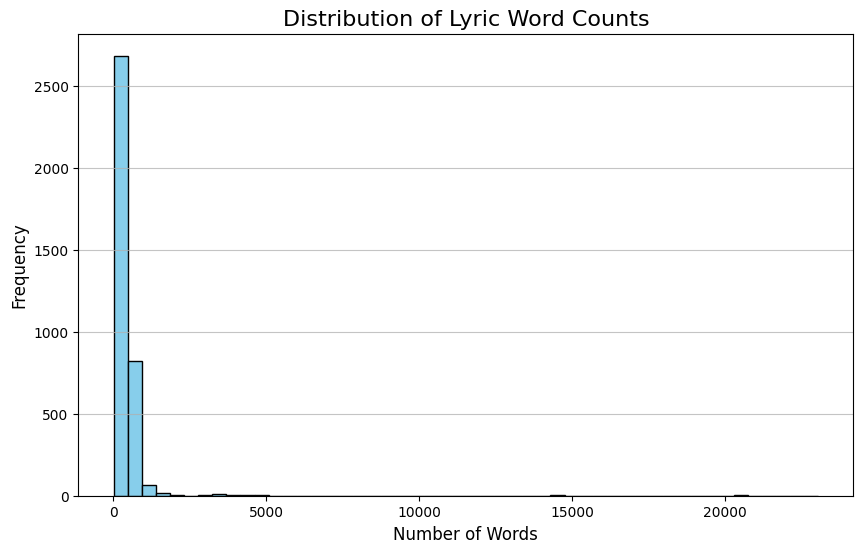

In [ ]:
df['word_count'] = df['lyrics'].str.split().str.len()
plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Lyric Word Counts', fontsize=16)
plt.xlabel('Number of Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()


In [ ]:
word_count = len(df)
df=df[df['word_count']<=1000]

print(f"Removed {original_rows - len(df)} rows with more than 1000 words.")
print(f"Remaining rows: {len(df)}")

Removed 250 rows with more than 800 words.
Remaining rows: 3391


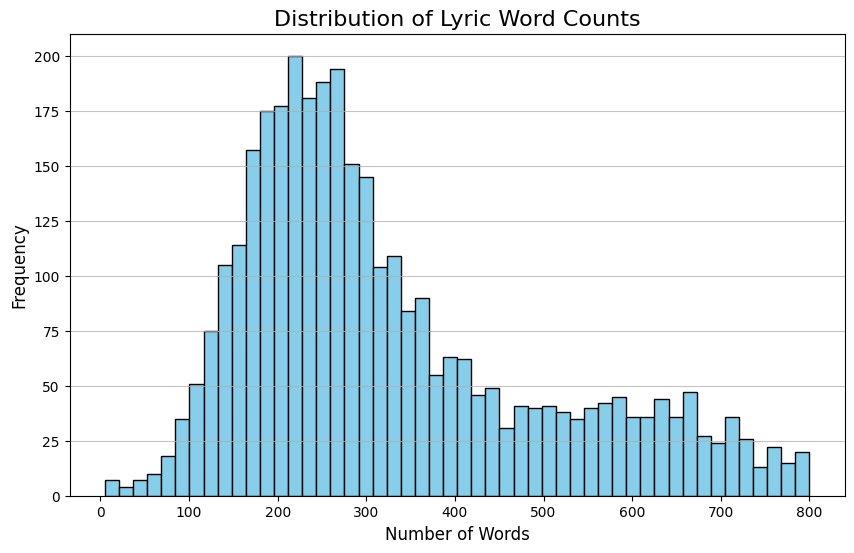

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Lyric Word Counts', fontsize=16)
plt.xlabel('Number of Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()


In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
custom_stop_words = {'ooh', 'aah', 'yeah', 'yeh', 'la', 'na', 'da'}
stop_words.update(custom_stop_words)

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A).lower()
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(lemmatized_tokens)


df['processed_lyrics'] = df['lyrics'].apply(preprocess_text)

In [ ]:
df.dropna(subset=['genre'], inplace=True)
df['genre_label'] = df['genre'].astype('category').cat.codes
label_to_genre = dict(enumerate(df['genre'].astype('category').cat.categories))
genre_to_label = {v: k for k, v in label_to_genre.items()}

print("Genre to Label Mapping:")
print(genre_to_label)

Genre to Label Mapping:
{'country': 0, 'hiphop': 1, 'rnb': 2, 'rock': 3}


In [ ]:
X = df['lyrics']
y = df['genre_label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 2712
Test set size: 679


In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression(max_iter=2000, random_state=42, solver='liblinear'))
])

parameters = {
    'tfidf__max_features': [4000, 5000, 7500],

    'tfidf__ngram_range': [(1, 1), (1, 2)],

    'tfidf__norm': ['l1', 'l2'],

    'clf__C': [1, 10, 20],
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=2)

print("Starting robust hyperparameter tuning...")
grid_search.fit(X_train, y_train)

print("\nBest parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(grid_search.best_score_))

best_model = grid_search.best_estimator_

Starting robust hyperparameter tuning...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters found:  {'clf__C': 1, 'tfidf__max_features': 7500, 'tfidf__ngram_range': (1, 1), 'tfidf__norm': 'l2'}
Best cross-validation accuracy: 0.6744



--- Final Model Evaluation on Test Set ---
              precision    recall  f1-score   support

     country       0.67      0.72      0.69       184
      hiphop       0.90      0.84      0.87       133
         rnb       0.59      0.58      0.58       177
        rock       0.61      0.61      0.61       185

    accuracy                           0.67       679
   macro avg       0.69      0.69      0.69       679
weighted avg       0.68      0.67      0.68       679



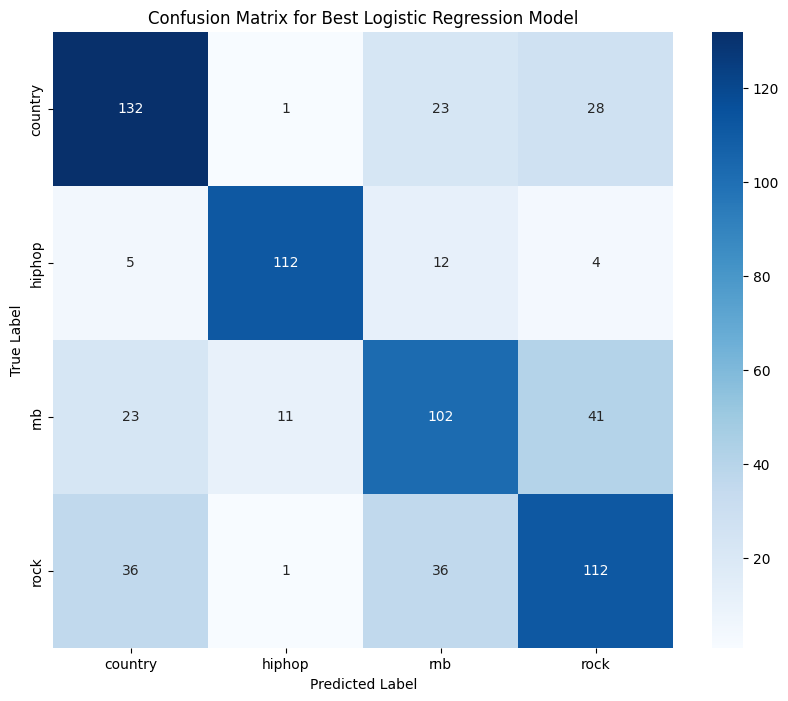

In [ ]:
y_pred = best_model.predict(X_test)

print("\n--- Final Model Evaluation on Test Set ---")

target_names = [label_to_genre[i] for i in sorted(label_to_genre)]
print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Best Logistic Regression Model')
plt.show()

# Analysis

In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

df = pd.read_csv('cleaned_rock_country_hiphop_rb.csv')
df.rename(columns={'type': 'genre'}, inplace=True)
genre_mapping = {'rap & hip hop': 'hiphop', 'R&B': 'rnb'}
df['genre'] = df['genre'].replace(genre_mapping)
df = df[['lyrics', 'genre']]
df.dropna(subset=['lyrics', 'genre'], inplace=True)
df.drop_duplicates(subset=['lyrics'], inplace=True)
df = df[df['lyrics'].str.split().str.len() >= 5]
df['song_title'] = df['lyrics'].str.split().str[:5].str.join(' ')

nltk.download('vader_lexicon', quiet=True)
vader = SentimentIntensityAnalyzer()

df['sentiment_scores'] = df['lyrics'].apply(lambda x: vader.polarity_scores(x))

df['positive_score'] = df['sentiment_scores'].apply(lambda x: x['pos'])
df['negative_score'] = df['sentiment_scores'].apply(lambda x: x['neg'])
df['neutral_score'] = df['sentiment_scores'].apply(lambda x: x['neu'])
df['compound_score'] = df['sentiment_scores'].apply(lambda x: x['compound'])


def get_sentiment_label(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_label'] = df['compound_score'].apply(get_sentiment_label)

print("Sentiment analysis columns added successfully.")
df[['song_title', 'genre', 'positive_score', 'negative_score', 'compound_score', 'sentiment_label']].head()

Sentiment analysis columns added successfully.


,song_title,genre,positive_score,negative_score,compound_score,sentiment_label
0,There's a lady who's sure,rock,0.094,0.028,0.9653,Positive
1,Once upon a time you,rock,0.084,0.107,-0.7488,Negative
2,We don't need no education,rock,0.055,0.155,-0.9257,Negative
3,We'll be fighting in the,rock,0.162,0.053,0.9848,Positive
4,On a dark desert highway,rock,0.129,0.035,0.9769,Positive


<ipython-input-19-2997703675>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.countplot(x='sentiment_label', data=df, palette='viridis', order=['Positive', 'Neutral', 'Negative'])


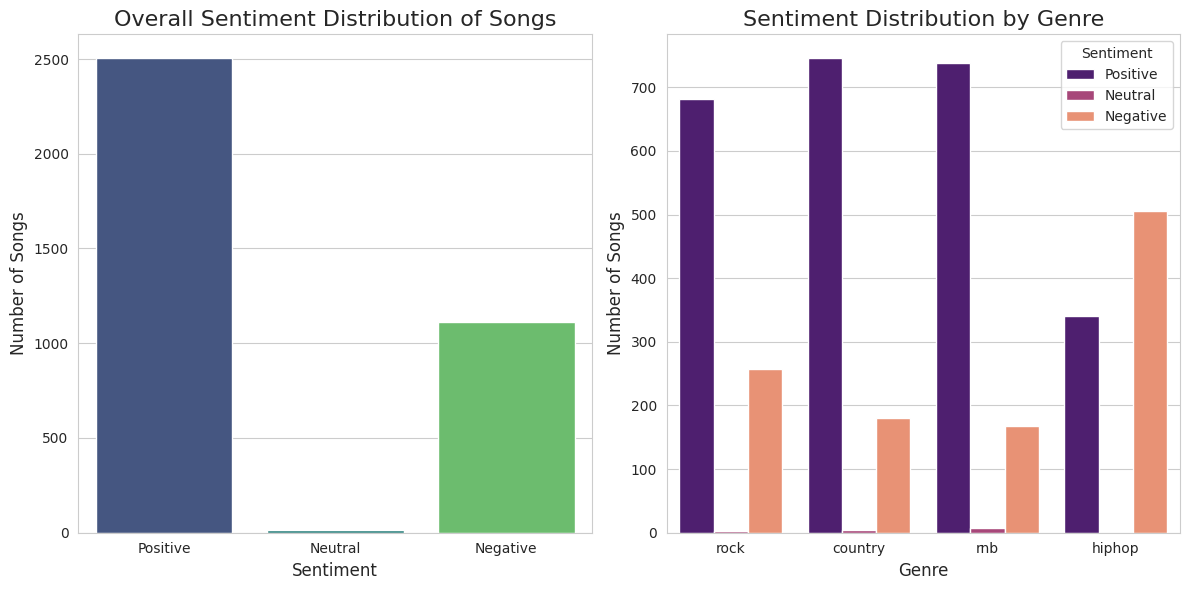

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
ax1 = sns.countplot(x='sentiment_label', data=df, palette='viridis', order=['Positive', 'Neutral', 'Negative'])
ax1.set_title('Overall Sentiment Distribution of Songs', fontsize=16)
ax1.set_xlabel('Sentiment', fontsize=12)
ax1.set_ylabel('Number of Songs', fontsize=12)

plt.subplot(1, 2, 2)
ax2 = sns.countplot(x='genre', hue='sentiment_label', data=df, palette='magma', hue_order=['Positive', 'Neutral', 'Negative'])
ax2.set_title('Sentiment Distribution by Genre', fontsize=16)
ax2.set_xlabel('Genre', fontsize=12)
ax2.set_ylabel('Number of Songs', fontsize=12)
plt.legend(title='Sentiment')

plt.tight_layout()
plt.show()

In [ ]:
top_10_positive_overall = df.nlargest(10, 'compound_score')[['song_title', 'genre', 'compound_score']]
top_10_negative_overall = df.nsmallest(10, 'compound_score')[['song_title', 'genre', 'compound_score']]

print("="*50)
print("Top 10 Most Positive Songs (Overall)")
print("="*50)
print(top_10_positive_overall.to_string(index=False))

print("\n" + "="*50)
print("Top 10 Most Negative Songs (Overall)")
print("="*50)
print(top_10_negative_overall.to_string(index=False))

print("\n" + "="*50)
print("Top Positive & Negative Songs by Genre")
print("="*50)

for genre in df['genre'].unique():
    print(f"\n--- Genre: {genre.upper()} ---")
    genre_df = df[df['genre'] == genre]

    top_positive = genre_df.nlargest(5, 'compound_score')[['song_title', 'compound_score']]
    top_negative = genre_df.nsmallest(5, 'compound_score')[['song_title', 'compound_score']]

    print("\nTop 5 Positive Songs:")
    print(top_positive.to_string(index=False))

    print("\nTop 5 Negative Songs:")
    print(top_negative.to_string(index=False))

Top 10 Most Positive Songs (Overall)
                              song_title   genre  compound_score
       High School Musical LyricsCUT TO:    rock          1.0000
                    that has had to come    rock          1.0000
Ulysses LyricsThe Mabbot street entrance country          1.0000
                Welcome to the Waking Up country          1.0000
                      What a pity! I beg     rnb          1.0000
        Ulysses LyricsI was just passing     rnb          1.0000
                Ain't nobody dope as me;  hiphop          1.0000
          Please, this shit's so fuckin'  hiphop          1.0000
             KIMMY: This is a year-round    rock          0.9999
            Remarks on Climate Change at    rock          0.9999

Top 10 Most Negative Songs (Overall)
                     song_title  genre  compound_score
                      ] ] ] ] ]   rock         -1.0000
          0-9 10cc 10 Years 100   rock         -1.0000
            and I said, this is    rnb       

Explicitness column added successfully.

Distribution of Explicit vs. Not Explicit Songs:
explicitness
Not Explicit    2551
Explicit        1078
Name: count, dtype: int64


<ipython-input-16-3941901020>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='explicitness', data=df, palette='coolwarm')


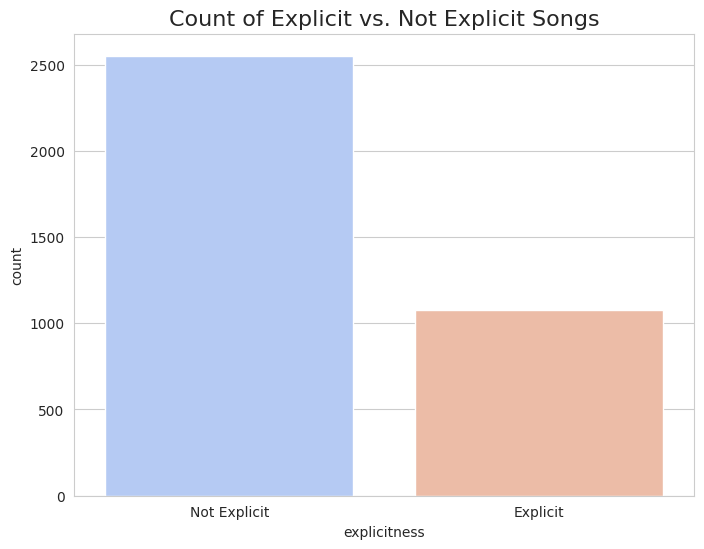

In [ ]:
profanity_list = set([
    'arse', 'arsehole', 'ass', 'asshat', 'asshole', 'bastard', 'bitch', 'bloody', 'bollocks', 'bugger',
    'bullshit', 'cock', 'crap', 'cunt', 'damn', 'dick', 'dickhead', 'fag', 'faggot', 'fuck', 'fucked',
    'fucker', 'fucking', 'hell', 'horseshit', 'motherfucker', 'nigga', 'piss', 'prick', 'pussy', 'shit',
    'slut', 'twat', 'wanker', 'whore'
])


def is_explicit(lyrics):
    words = set(re.findall(r'\b\w+\b', lyrics.lower()))
    if any(word in profanity_list for word in words):
        return 'Explicit'
    else:
        return 'Not Explicit' 

df['explicitness'] = df['lyrics'].apply(is_explicit)

print("Explicitness column added successfully.\n")
print("Distribution of Explicit vs. Not Explicit Songs:")
print(df['explicitness'].value_counts())


plt.figure(figsize=(8, 6))
ax = sns.countplot(x='explicitness', data=df, palette='coolwarm')
ax.set_title('Count of Explicit vs. Not Explicit Songs', fontsize=16)
plt.show()

Top 20 Most Common Words (excluding stop words):
     Word  Count
0    love   8692
1    know   8135
2    dont   8071
3    baby   5404
4     one   5098
5    time   5027
6     let   4499
7    come   4446
8    make   4428
9   cause   4288
10    see   4207
11  nigga   4105
12    man   3999
13   back   3945
14   aint   3766
15  youre   3755
16    say   3727
17  never   3678
18    way   3659
19   want   3564


<ipython-input-17-1562800837>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=top_words_df, palette='plasma')


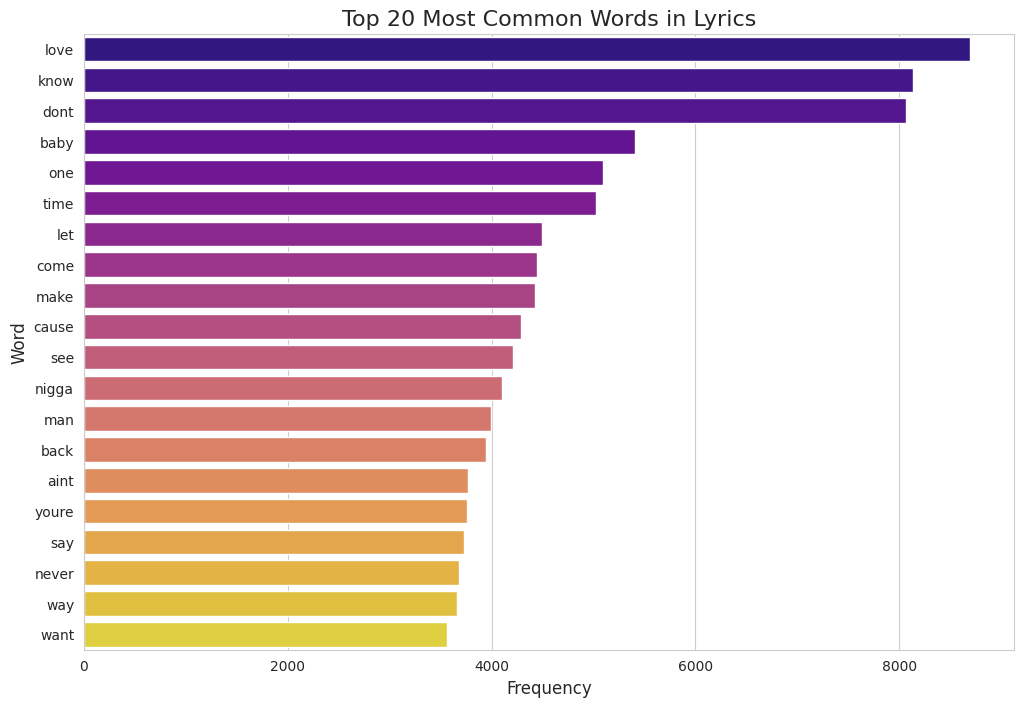

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
custom_stop_words = {'ooh', 'aah', 'yeah', 'yeh', 'la', 'na', 'da', 'gon', 'wan', 'got', 'get', 'like', 'oh', 'im'}
stop_words.update(custom_stop_words)

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A).lower()
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return lemmatized_tokens

all_words = df['lyrics'].apply(preprocess_text).sum()

word_counts = Counter(all_words)

top_20_words = word_counts.most_common(20)
top_words_df = pd.DataFrame(top_20_words, columns=['Word', 'Count'])

print("Top 20 Most Common Words (excluding stop words):")
print(top_words_df)

plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Word', data=top_words_df, palette='plasma')
plt.title('Top 20 Most Common Words in Lyrics', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Word', fontsize=12)
plt.show()

Analyzing explicit songs...

--- Top 20 Words in EXPLICIT Songs ---
     Word  Count
0   nigga   4066
1    shit   2259
2    love   2187
3    back   2055
4    life   1531
5   right   1496
6    fuck   1493
7    want   1385
8    keep   1227
9    good   1116
10   need   1087
11  bitch   1080
12   said   1068
13    big   1045
14  think   1016
15  money   1015
16   give    999
17   girl    994
18   tell    985
19   feat    957

Analyzing non-explicit songs...

--- Top 20 Words in NON-EXPLICIT Songs ---
      Word  Count
0     love   6509
1     want   2180
2     girl   2117
3     back   1891
4    night   1740
5    right   1723
6   little   1540
7     good   1535
8     need   1512
9     tell   1512
10    life   1437
11    said   1362
12   heart   1327
13    away   1315
14   think   1243
15    keep   1240
16    give   1168
17    long   1100
18   woman   1065
19  around   1026


<ipython-input-18-1805288610>:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x='Count', y='Word', data=top_20_explicit, palette='Reds_r')
<ipython-input-18-1805288610>:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x='Count', y='Word', data=top_20_non_explicit, palette='Greens_r')


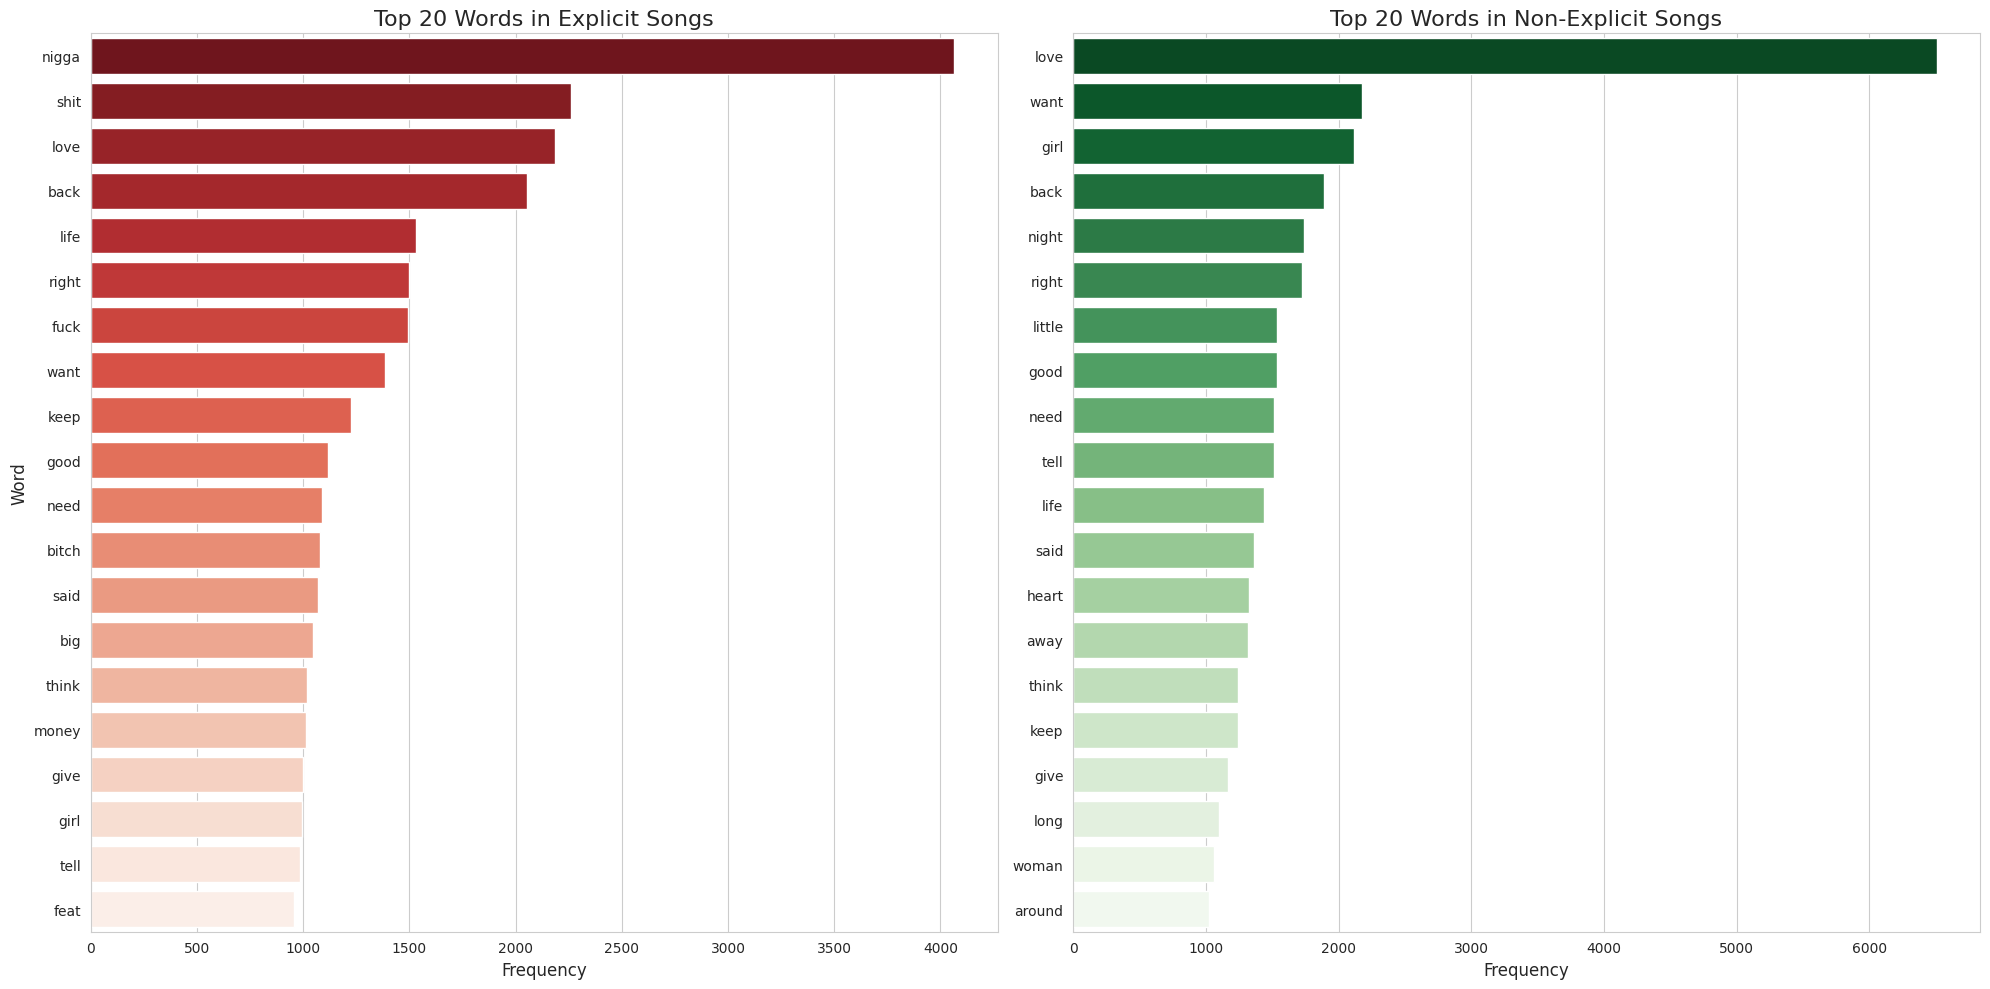

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.word_tokenize('test')
except LookupError:
    nltk.download('punkt')
try:
    WordNetLemmatizer().lemmatize('test')
except LookupError:
    nltk.download('wordnet')


contraction_mapping = {
    "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
    "couldn't": "could not", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not",
    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is",
    "how'd": "how did", "how'll": "how will", "how's": "how is", "i'd": "i would", "i'll": "i will",
    "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'll": "it will",
    "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
    "mightn't": "might not", "must've": "must have", "mustn't": "must not", "needn't": "need not",
    "o'clock": "of the clock", "oughtn't": "ought not", "shan't": "shall not", "sha'n't": "shall not",
    "she'd": "she would", "she'll": "she will", "she's": "she is", "should've": "should have",
    "shouldn't": "should not", "so've": "so have","so's": "so is", "that'd": "that would",
    "that's": "that is", "there'd": "there would", "there's": "there is", "they'd": "they would",
    "they'll": "they will", "they're": "they are", "they've": "they have", "to've": "to have",
    "wasn't": "was not", "we'd": "we would", "we'll": "we will", "we're": "we are", "we've": "we have",
    "weren't": "were not", "what'll": "what will", "what're": "what are", "what's": "what is",
    "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
    "where's": "where is", "where've": "where have", "who'll": "who will", "who's": "who is",
    "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
    "won't": "will not", "would've": "would have", "wouldn't": "would not", "y'all": "you all",
    "you'd": "you would", "you'll": "you will", "you're": "you are", "you've": "you have"
}

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
custom_stop_words = {
    'ooh', 'aah', 'yeah', 'yeh', 'la', 'na', 'da', 'oh', 'yo', 'hey', 'uh',
    'im', 'gon', 'wan', 'wanna', 'gonna', 'gotta', 'em', 'cause', 'aint',
    'got', 'get', 'know', 'like', 'see', 'say', 'come', 'go', 'make',
    'take', 'let', 'feel', 'one', 'man', 'thing', 'baby', 'time', 'day',
    'way', 'never', 'ever', 'every', 'always', 'still', 'even', 'well',
    'could', 'would'
}
stop_words.update(custom_stop_words)

def final_preprocess_text(text):
    if not isinstance(text, str):
        return []
    text = text.lower()
    for contraction, expansion in contraction_mapping.items():
        text = text.replace(contraction, expansion)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return processed_tokens


explicit_df = df[df['explicitness'] == 'Explicit'].copy()
non_explicit_df = df[df['explicitness'] == 'Not Explicit'].copy()

print("Analyzing explicit songs...")
explicit_words = explicit_df['lyrics'].apply(final_preprocess_text).sum()
explicit_word_counts = Counter(explicit_words)
top_20_explicit = pd.DataFrame(explicit_word_counts.most_common(20), columns=['Word', 'Count'])
print("\n--- Top 20 Words in EXPLICIT Songs ---")
print(top_20_explicit)

print("\nAnalyzing non-explicit songs...")
non_explicit_words = non_explicit_df['lyrics'].apply(final_preprocess_text).sum()
non_explicit_word_counts = Counter(non_explicit_words)
top_20_non_explicit = pd.DataFrame(non_explicit_word_counts.most_common(20), columns=['Word', 'Count'])
print("\n--- Top 20 Words in NON-EXPLICIT Songs ---")
print(top_20_non_explicit)


fig, axes = plt.subplots(1, 2, figsize=(20, 10))

sns.barplot(ax=axes[0], x='Count', y='Word', data=top_20_explicit, palette='Reds_r')
axes[0].set_title('Top 20 Words in Explicit Songs', fontsize=16)
axes[0].set_xlabel('Frequency', fontsize=12)
axes[0].set_ylabel('Word', fontsize=12)

sns.barplot(ax=axes[1], x='Count', y='Word', data=top_20_non_explicit, palette='Greens_r')
axes[1].set_title('Top 20 Words in Non-Explicit Songs', fontsize=16)
axes[1].set_xlabel('Frequency', fontsize=12)
axes[1].set_ylabel('')
plt.tight_layout()
plt.show()